# Working with MODIS for Land Cover and LAI data

## Download MODIS data from AppEARS

MODIS provides satellite image data including ET, LAI and etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [3]:
import logging
import os
import numpy as np
from matplotlib import pyplot as plt
import cftime, datetime

import watershed_workflow
import watershed_workflow.sources
import watershed_workflow.land_cover_properties
import watershed_workflow.io
import watershed_workflow.data



In [4]:
watershed_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
crs = watershed_workflow.crs.default_crs

### Get the watershed

In [5]:
watershed_shapes = watershed_workflow.sources.ManagerShapefile(watershed_shapefile).getShapes(out_crs=crs)
watershed = watershed_workflow.SplitHUCs(watershed_shapes)
watershed_workflow.split_hucs.simplify(watershed, 60)

bounds = watershed.exterior.bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2025-08-29 14:32:50,821 - root - INFO: fixing column: geometry
2025-08-29 14:32:50,826 - root - INFO: Removing holes on 1 polygons
2025-08-29 14:32:50,826 - root - INFO:   -- removed interior
2025-08-29 14:32:50,826 - root - INFO:   -- union
2025-08-29 14:32:50,827 - root - INFO: Parsing 1 components for holes
2025-08-29 14:32:50,827 - root - INFO:   -- complete


(1129295.2795668324, 1404623.589635828, 1134445.5249643093, 1410000.8473600943)
5150.245397476945 5377.257724266266


### Download the data

In [6]:
source = watershed_workflow.sources.ManagerMODISAppEEARS()

In [7]:
start_year = 2010
end_year = 2014

startdate = f"{start_year}-1-1"
enddate = f"{end_year}-12-31"

# note that AppEEARS typically takes a few minutes to prepare your data.  Therefore we return a task, which can be re-checked later.  
# So you could launch this call more-or-less immediately upon entering your workflow, continue the workflow, then call wait after
# all your other work is done.  Here we just immediately call wait, which checks every few minutes to see if AppEEARs is ready.
task = source.requestDataset(watershed.exterior.buffer(1000), watershed.crs, startdate, enddate) 

2025-08-29 14:32:50,853 - root - INFO: Incoming shape area = 0.0035508368181677618
2025-08-29 14:32:50,854 - root - INFO: ... buffering incoming shape by = 0.0045000000000000005
2025-08-29 14:32:50,854 - root - INFO: ... buffered shape area = 0.004621760927923991
2025-08-29 14:32:50,855 - root - INFO: Building request for bounds: [np.float64(-83.494), np.float64(35.0139), np.float64(-83.4061), np.float64(35.0873)]
2025-08-29 14:32:50,855 - root - INFO: ... requires files:
2025-08-29 14:32:50,856 - root - INFO:  ... /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LAI_01-01-2010_12-31-2014_35.0873x-83.4940_35.0139x-83.4061.nc
2025-08-29 14:32:50,856 - root - INFO:  ... /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LULC_01-01-2010_12-31-2014_35.0873x-83.4940_35.0139x-83.4061.nc
2025-08-29 14:32:50,856 - root - INFO: ... building request.
2025-08-29 14:32:53,417 - root - INFO: Requested AppEEARS MODIS dataset on [np.float64(-83.494), np.float64(35.0139), n

In [8]:
# This task_id is the magic key used to identify with AppEEARs what job you're referring to.  It gets used to check the status of the job, and download the result when it is ready.
# Note that AppEEARs will send you an email when the job is done!
print(task.task_id)

48ee1016-64d7-4918-b0c7-d2c5df8f2280


In [9]:
# Do other stuff...
#

# check whether the request is done
if source.isReady(task):
    # fetch the request
    data = source.fetchDataset(task)


2025-08-29 14:32:53,461 - root - INFO: Checking status of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:53,647 - root - INFO: ... http error
2025-08-29 14:32:53,649 - root - INFO: Checking for bundle of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:53,874 - root - INFO: ... HTTPError checking for bundle:
2025-08-29 14:32:53,875 - root - INFO: 404 Client Error: NOT FOUND for url: https://appeears.earthdatacloud.nasa.gov/api/bundle/48ee1016-64d7-4918-b0c7-d2c5df8f2280


In [10]:
# call this as many times as you want until it works!
#
# Note that you can also check the status of your request on the AppEEARS website.  Login and click on "Explore" to see your running tasks.
if source.isReady(task):
    # fetch the request
    data = source.fetchDataset(task)

2025-08-29 14:32:53,916 - root - INFO: Checking status of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:54,239 - root - INFO: ... http error
2025-08-29 14:32:54,241 - root - INFO: Checking for bundle of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:54,594 - root - INFO: ... HTTPError checking for bundle:
2025-08-29 14:32:54,595 - root - INFO: 404 Client Error: NOT FOUND for url: https://appeears.earthdatacloud.nasa.gov/api/bundle/48ee1016-64d7-4918-b0c7-d2c5df8f2280


In [11]:
# then when you really need the data, you can just wait.  This simply calls isReady then sleeps, in a loop, until isReady returns true.
data = source.waitForDataset(task)

2025-08-29 14:32:54,625 - root - INFO: Checking status of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:54,860 - root - INFO: ... http error
2025-08-29 14:32:54,862 - root - INFO: Checking for bundle of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:55,201 - root - INFO: ... HTTPError checking for bundle:
2025-08-29 14:32:55,203 - root - INFO: 404 Client Error: NOT FOUND for url: https://appeears.earthdatacloud.nasa.gov/api/bundle/48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:32:55,205 - root - INFO: MODIS request not ready, sleeping 120s...
2025-08-29 14:34:55,206 - root - INFO: Checking status of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:34:55,408 - root - INFO: ... http error
2025-08-29 14:34:55,410 - root - INFO: Checking for bundle of task: 48ee1016-64d7-4918-b0c7-d2c5df8f2280
2025-08-29 14:34:55,638 - root - INFO: ... HTTPError checking for bundle:
2025-08-29 14:34:55,638 - root - INFO: 404 Client Error: NOT FOUND for url: https://ap

Check for outliers in the data, and fix if needed.

In [16]:
# LAI extent
print('LAI:', data['LAI'].values.min(), data['LAI'].values.max())

# LULC extent
print('LULC:', data['LULC'].values.min(), data['LULC'].values.max())

modis_data = data


LAI: 0.0 7.0
LULC: 4.0 8.0


## Compute time series of LAI

First, MODIS is "real" data, and so has leap year.  Our runs do not include leap year, so we first convert to a noleap calendar by dropping leap day data.

In [17]:
# MODIS data comes with time-dependent LAI AND time-dependent LULC -- just take the mode to find the most common LULC
modis_data['LULC'] = watershed_workflow.data.computeMode(modis_data['LULC'], 'time_LULC')

# now it is safe to have only one time
modis_data = modis_data.rename({'time_LAI':'time'})

# remove leap day (366th day of any leap year) to match our Noleap Calendar
modis_data = watershed_workflow.data.filterLeapDay(modis_data)

### Form the dynamic time-series.

The raw data is integrated in space by intersecting each LULC index with the LAI raster and summing over that mask.  This is done for each time of LAI observation to form a time series.

In [26]:
# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)
lai_df

time  Deciduous Broadleaf Forests LAI [-]
0    2009-12-31 00:00:00                             0.540426
1    2010-01-01 00:00:00                             0.540426
2    2010-01-05 00:00:00                             0.589362
3    2010-01-09 00:00:00                             0.579787
4    2010-01-13 00:00:00                             0.642553
..                   ...                                  ...
456  2014-12-15 00:00:00                             0.704255
457  2014-12-19 00:00:00                             0.461702
458  2014-12-23 00:00:00                             0.718085
459  2014-12-27 00:00:00                             0.589362
460  2014-12-31 00:00:00                             0.503191

[461 rows x 2 columns]

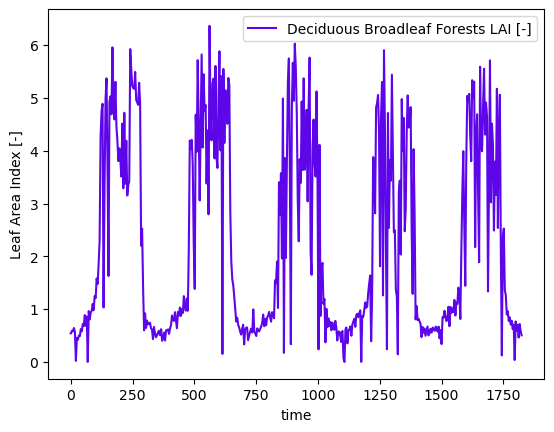

In [32]:
# plot the dynamic data
fig = plt.figure()
ax = fig.add_subplot(111)

ts = cftime.date2num(lai_df['time'], f'days since {start_year}-01-01')  
for column in lai_df:
    if column != 'time':
        ax.plot(ts, lai_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()


### Form data for a typical year

In addition to the dynamic data, we need a typical year for cyclic steadystate spinup purposes.

In [33]:
# also compute a typical year of LAI
typical_df = watershed_workflow.data.computeAverageYear(lai_df, 'time', output_nyears=10, 
                                                                  start_year=2000)


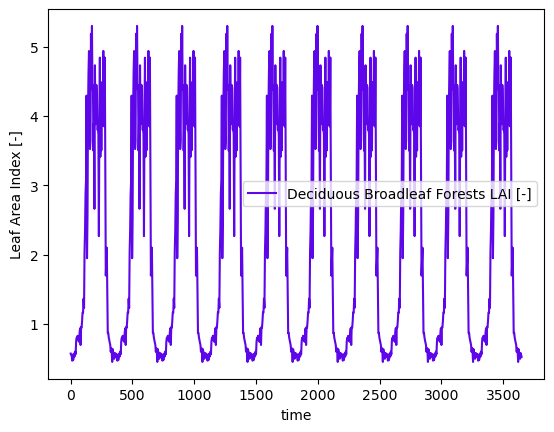

In [34]:
# plot the dynamic data
fig = plt.figure()
ax = fig.add_subplot(111)

ts = cftime.date2num(typical_df['time'], f'days since 2000-01-01')  
for column in typical_df:
    if column != 'time':
        ax.plot(ts, typical_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()